# What is A/B Testing ?


A/B Testing is a tried-and-true method commonly performed using a traditional statistical inference approach grounded in a hypothesis test (e.g. t-test, z-score, chi-squared test). In plain English, 2 tests are run in parallel:

Treatment Group (Group A) - This group is exposed to the new web page, popup form, etc.

Control Group (Group B) - This group experiences no change from the current setup.

The goal of the A/B is then to compare the conversion rates of the two groups using statistical inference.

The problem is that the world is not a vacuum involving only the experiment (treatment vs control group) and effect. The situation is vastly more complex and dynamic. Consider these situations:

Users have different characteristics: Different ages, genders, new vs returning, etc

Users spend different amounts of time on the website: Some hit the page right away, others spend more time on the site

Users are find your website differently: Some come from email or newsletters, others from web searches, others from social media

Users take different paths: Users take actions on the website going to different pages prior to being confronted with the event and goal

# Business Statment 

**In the experiment, Udacity tested a change where if the student clicked “start free trial”, they were asked how much time they had available to devote to the course.**

**If the student indicated 5 or more hours per week, they would be taken through the checkout process as usual. If they indicated fewer than 5 hours per week, a message would appear indicating that Udacity courses usually require a greater time commitment for successful completion.**

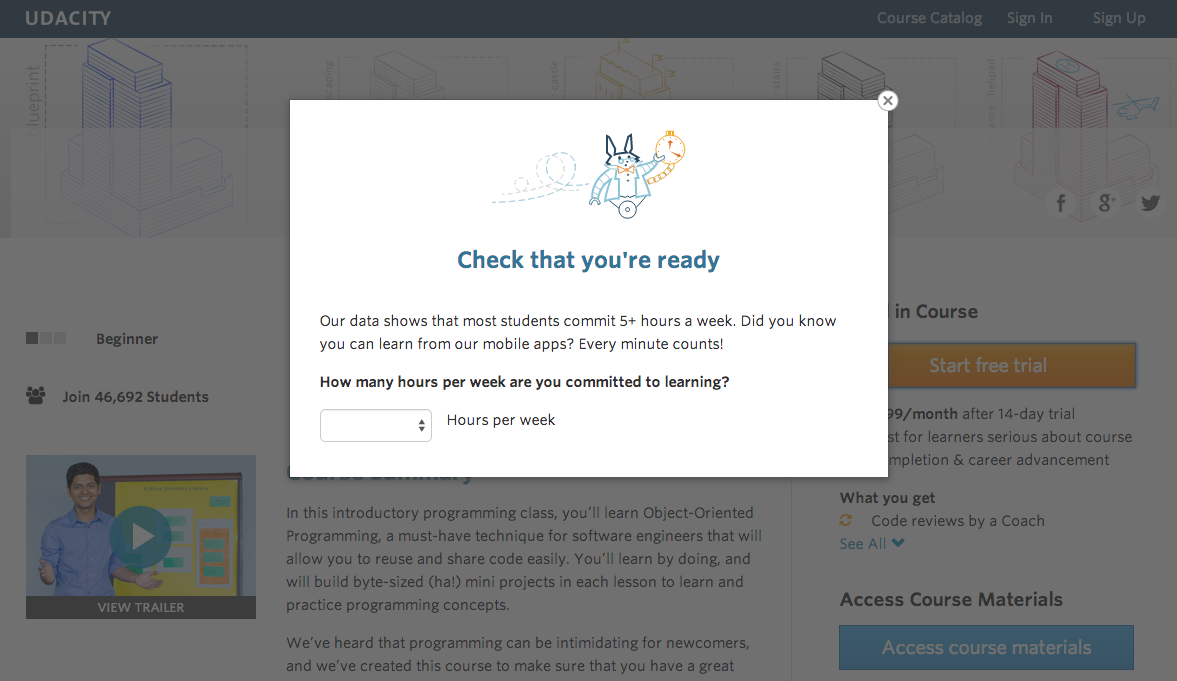

The goal with this popup was that this might set clearer expectations for students upfront, thus reducing the number of frustrated students who left the free trial because they didn’t have enough time.

However, what Udacity wants to avoid is “significantly” reducing the number of students that continue past the free trial and eventually complete the course.


# Goal


In this analysis, we will investigate which features are contributing enrollments and determine if there is an impact on enrollments from the new “Setting Expectations” form.

The users that experience the form will be denoted as “Experiment = 1”
The control group (users that don’t see the form) will be denoted as “Experiment = 0”.

Loading Packages

In [2]:
library(tidyverse)
library(tidyquant)
library(parsnip)
library(recipes)
library(rsample)
library(yardstick)
library(broom)

library(rpart)
library(rpart.plot)
library(xgboost)

In [3]:
control_tbl <- read.csv('../input/control-data/control_data.csv')

experiment_tbl <- read.csv('../input/experiment-data/experiment_data.csv')

In [4]:
control_tbl %>% head(5)

,Date,Pageviews,Clicks,Enrollments,Payments
,<chr>,<int>,<int>,<int>,<int>
1,"Sat, Oct 11",7723,687,134,70
2,"Sun, Oct 12",9102,779,147,70
3,"Mon, Oct 13",10511,909,167,95
4,"Tue, Oct 14",9871,836,156,105
5,"Wed, Oct 15",10014,837,163,64


We have 5 columns consisting of:

**Date**: a character formatted Day, Month, and Day of Month

**Pageviews**: An aggregated count of Page Views on the given day

**Clicks**: An aggregated count of Page Clicks on the given day for the page in question

**Enrollments**: An aggregated count of Enrollments by day.

**Payments**: An aggregated count of Payments by day.

**To study Data format**

In [5]:
control_tbl %>% glimpse()

Rows: 37
Columns: 5
$ Date        <chr> "Sat, Oct 11", "Sun, Oct 12", "Mon, Oct 13", "Tue, Oct 14"…
$ Pageviews   <int> 7723, 9102, 10511, 9871, 10014, 9670, 9008, 7434, 8459, 10…
$ Clicks      <int> 687, 779, 909, 836, 837, 823, 748, 632, 691, 861, 867, 838…
$ Enrollments <int> 134, 147, 167, 156, 163, 138, 146, 110, 131, 165, 196, 162…
$ Payments    <int> 70, 70, 95, 105, 64, 82, 76, 70, 60, 97, 105, 92, 56, 122,…


In [6]:
experiment_tbl %>% glimpse()

Rows: 37
Columns: 5
$ Date        <chr> "Sat, Oct 11", "Sun, Oct 12", "Mon, Oct 13", "Tue, Oct 14"…
$ Pageviews   <int> 7716, 9288, 10480, 9867, 9793, 9500, 9088, 7664, 8434, 104…
$ Clicks      <int> 686, 785, 884, 827, 832, 788, 780, 652, 697, 860, 864, 801…
$ Enrollments <int> 105, 116, 145, 138, 140, 129, 127, 94, 120, 153, 143, 128,…
$ Payments    <int> 34, 91, 79, 92, 94, 61, 44, 62, 77, 98, 71, 70, 68, 94, 81…


Key Points:

37 total observations in the control set and 37 in the experiment set

Data is time-based and aggregated by day - This isn’t the best way to understand complex user behavior, 

We can see that Date is formatted as a character data type. This will be important when we get to data quality. We’ll extract day of the week features out of it.

Data between the experiment group and the control group is in the same format. Same number of observations (37 days) since the groups were tested in parallel.

# EDA

**Missing Values**

In [7]:
control_tbl %>%
    map_df(~ sum(is.na(.))) %>%
    gather(key = "feature", value = "missing_count") %>%
    arrange(desc(missing_count))

feature,missing_count
<chr>,<int>
Enrollments,14
Payments,14
Date,0
Pageviews,0
Clicks,0


Key Point: We have 14 days of missing observations that we need to investigate

Let’s see if the missing data (NA) is consistent in the experiment set.

In [8]:
experiment_tbl %>% 
    map_df(~ sum(is.na(.))) %>%
    gather(key = "feature", value = "missing_count") %>%
    arrange(desc(missing_count))

feature,missing_count
<chr>,<int>
Enrollments,14
Payments,14
Date,0
Pageviews,0
Clicks,0


**Let’s see which values are missing**

In [9]:
control_tbl %>%
    filter(is.na(Enrollments))

Date,Pageviews,Clicks,Enrollments,Payments
<chr>,<int>,<int>,<int>,<int>
"Mon, Nov 3",9437,788,NA,NA
"Tue, Nov 4",9420,781,NA,NA
"Wed, Nov 5",9570,805,NA,NA
"Thu, Nov 6",9921,830,NA,NA
"Fri, Nov 7",9424,781,NA,NA
"Sat, Nov 8",9010,756,NA,NA
"Sun, Nov 9",9656,825,NA,NA
"Mon, Nov 10",10419,874,NA,NA
"Tue, Nov 11",9880,830,NA,NA


**We don’t have Enrollment information from November 3rd on. We will need to remove these observations.**

In [10]:
control_tbl %>% glimpse()

Rows: 37
Columns: 5
$ Date        <chr> "Sat, Oct 11", "Sun, Oct 12", "Mon, Oct 13", "Tue, Oct 14"…
$ Pageviews   <int> 7723, 9102, 10511, 9871, 10014, 9670, 9008, 7434, 8459, 10…
$ Clicks      <int> 687, 779, 909, 836, 837, 823, 748, 632, 691, 861, 867, 838…
$ Enrollments <int> 134, 147, 167, 156, 163, 138, 146, 110, 131, 165, 196, 162…
$ Payments    <int> 70, 70, 95, 105, 64, 82, 76, 70, 60, 97, 105, 92, 56, 122,…


**Date is in character format. It doesn’t contain year information. Since the experiment was only run for 37 days, we can only realistically use the “Day of Week” as a predictor.**

**The other columns are all numeric, which is OK. We will predict the number of Enrollments**

**Payments is an outcome of Enrollments so this should be removed.**

# Data Cleaning

**Combine the control_tbl and experiment_tbl, adding an “id” column indicating if the data was part of the experiment or not**

**Add a “row_id” column to help for tracking which rows are selected for training and testing in the modeling section**

**Create a “Day of Week” feature from the “Date” column**

**Drop the unnecessary “Date” column and the “Payments” column**

**Handle the missing data (NA) by removing these rows.**

**Shuffle the rows to mix the data up for learning**

**Reorganize the columns**

In [11]:
set.seed(123)
data_formatted_tbl <- control_tbl %>%
    
    # Combine with Experiment data
    bind_rows(experiment_tbl, .id = "Experiment") %>%
    mutate(Experiment = as.numeric(Experiment) - 1) %>%
    
    # Add row id
    mutate(row_id = row_number()) %>%
    
    # Create a Day of Week feature
    mutate(DOW = str_sub(Date, start = 1, end = 3) %>% 
               factor(levels = c("Sun", "Mon", "Tue", "Wed", 
                                 "Thu", "Fri", "Sat"))
           ) %>%
    select(-Date, -Payments) %>%
    
    # Remove missing data
    filter(!is.na(Enrollments)) %>%
    
    # Shuffle the data (note that set.seed is used to make reproducible)
    sample_frac(size = 1) %>%
    
    # Reorganize columns
    select(row_id, Enrollments, Experiment, everything())

In [12]:
data_formatted_tbl %>% glimpse()

Rows: 46
Columns: 6
$ row_id      <int> 45, 15, 14, 3, 56, 51, 58, 39, 40, 41, 5, 55, 42, 9, 43, 5…
$ Enrollments <int> 94, 176, 220, 167, 201, 194, 182, 116, 145, 138, 163, 162,…
$ Experiment  <dbl> 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0…
$ Pageviews   <int> 7664, 8687, 9434, 10511, 9262, 9402, 8715, 9288, 10480, 98…
$ Clicks      <int> 652, 691, 673, 909, 727, 697, 722, 785, 884, 827, 837, 736…
$ DOW         <fct> Sat, Sat, Fri, Mon, Wed, Fri, Fri, Sun, Mon, Tue, Wed, Tue…


**Cross Validation**

In [13]:
set.seed(123)
split_obj <- data_formatted_tbl %>%
    initial_split(prop = 0.8, strata = "Experiment")

train_tbl <- training(split_obj)
test_tbl  <- testing(split_obj) 

In [14]:
train_tbl %>% glimpse()

Rows: 36
Columns: 6
$ row_id      <int> 15, 3, 5, 9, 8, 19, 4, 17, 11, 13, 20, 23, 18, 21, 6, 1, 2…
$ Enrollments <int> 176, 167, 163, 131, 110, 196, 156, 233, 196, 127, 167, 206…
$ Experiment  <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1…
$ Pageviews   <int> 8687, 10511, 10014, 8459, 7434, 9327, 9871, 9535, 10660, 8…
$ Clicks      <int> 691, 909, 837, 691, 632, 739, 836, 759, 867, 665, 734, 693…
$ DOW         <fct> Sat, Mon, Wed, Sun, Sat, Wed, Tue, Mon, Tue, Thu, Thu, Sun…


In [15]:
test_tbl %>% glimpse()

Rows: 10
Columns: 6
$ row_id      <int> 14, 40, 52, 7, 10, 12, 59, 49, 22, 60
$ Enrollments <int> 220, 145, 127, 146, 165, 162, 142, 128, 156, 182
$ Experiment  <dbl> 0, 1, 1, 0, 0, 0, 1, 1, 0, 1
$ Pageviews   <int> 9434, 10480, 8669, 9008, 10667, 9947, 8448, 9737, 8460, 88…
$ Clicks      <int> 673, 884, 669, 748, 861, 838, 695, 801, 681, 724
$ DOW         <fct> Fri, Mon, Sat, Fri, Mon, Wed, Sat, Wed, Sat, Sun


# **Machine Learning Models**

Our strategy will be to implement 3 modeling approaches:

-Linear Regression

-Decision Tree

-XGBoost



# Linear Regression

In [16]:
model_01_lm <- linear_reg("regression") %>%
    set_engine("lm") %>%
    fit(Enrollments ~ ., data = train_tbl %>% select(-row_id))

In [17]:
model_01_lm %>%
    predict(new_data = test_tbl) %>%
    bind_cols(test_tbl %>% select(Enrollments)) %>%
    metrics(truth = Enrollments, estimate = .pred) %>%
    knitr::kable()



|.metric |.estimator |  .estimate|
|:-------|:----------|----------:|
|rmse    |standard   | 32.1813991|
|rsq     |standard   |  0.3444336|
|mae     |standard   | 27.7148176|

In [ ]:
model_01_lm %>%
    # Format Data
    predict(test_tbl) %>%
    bind_cols(test_tbl %>% select(Enrollments)) %>%
    mutate(observation = row_number() %>% as.character()) %>%
    gather(key = "key", value = "value", -observation, factor_key = TRUE) %>%
    
    # Visualize
    ggplot(aes(x = observation, y = value, color = key)) +
    geom_point() +
    expand_limits(y = 0) +
    theme_tq() +
    scale_color_tq() +
    labs(title = "Enrollments: Prediction vs Actual",
         subtitle = "Model 01: Linear Regression (Baseline)")

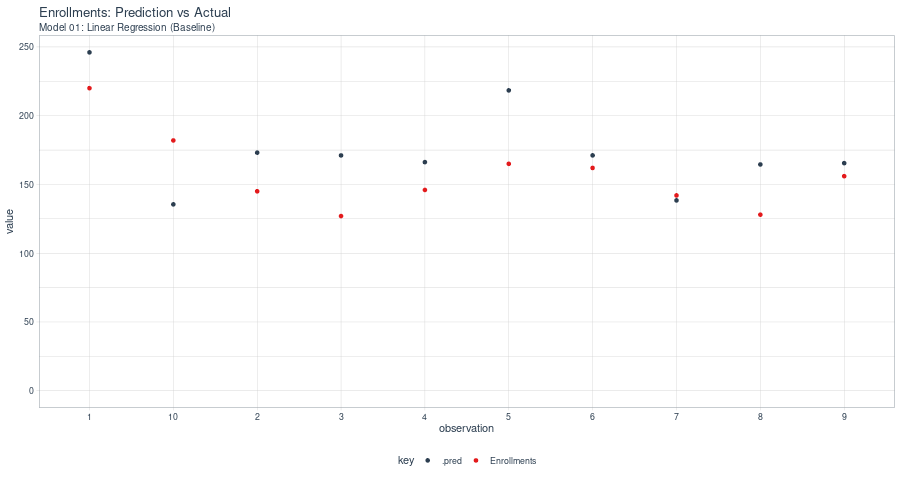

In [18]:
linear_regression_model_terms_tbl <- model_01_lm$fit %>%
    tidy() %>%
    arrange(p.value) %>%
    mutate(term = as_factor(term) %>% fct_rev()) 

# knitr::kable() used for pretty tables
linear_regression_model_terms_tbl %>% knitr::kable()



|term        |    estimate|  std.error|  statistic|   p.value|
|:-----------|-----------:|----------:|----------:|---------:|
|Clicks      |  -0.6709381|  0.1351726| -4.9635647| 0.0000370|
|Pageviews   |   0.0692229|  0.0154320|  4.4856713| 0.0001306|
|Experiment  | -16.8809060|  7.3964356| -2.2823029| 0.0308955|
|DOWMon      |  31.1476094| 17.1397658|  1.8172716| 0.0807195|
|DOWFri      |  18.0185100| 14.0265834|  1.2845972| 0.2102610|
|DOWWed      |  18.3067550| 15.1370069|  1.2094039| 0.2373904|
|DOWSat      |  10.2618805| 16.4042902|  0.6255608| 0.5370559|
|DOWThu      |  -6.6848206| 12.3334080| -0.5420092| 0.5924275|
|(Intercept) |  26.5108797| 77.5271192|  0.3419562| 0.7351325|
|DOWTue      |  -4.6330479| 15.4975121| -0.2989543| 0.7673515|

In [ ]:
linear_regression_model_terms_tbl %>%
    ggplot(aes(x = p.value, y = term)) +
    geom_point(color = "#2C3E50") +
    geom_vline(xintercept = 0.05, linetype = 2, color = "red") +
    theme_tq() +
    labs(title = "Feature Importance",
         subtitle = "Model 01: Linear Regression (Baseline)")

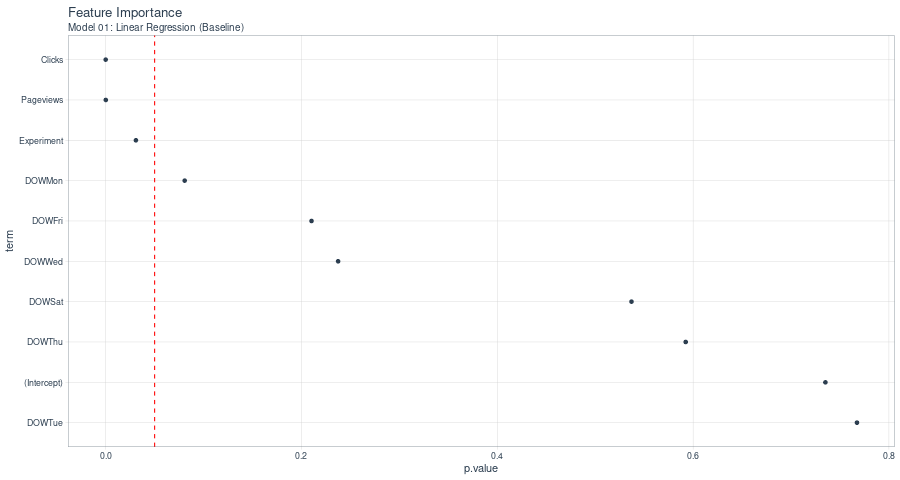

Key Points:

**Our model is on average off by +/-27.7 enrollments (means absolute error). The test set R-squared is quite low at 0.06.**


**We investigated feature importance. Clicks, Pageviews, and Experiment are the most important features. Experiment is 3rd, with a p.value 0.026. Typically this is considered significant.**

**We can also see the term coefficient for Experiment is -16.8 indicating as decreasing Enrollments by -17.6 per day when the Experiment is run.**

**Creating repetitive Code below **

In [21]:
calc_metrics <- function(model, new_data) {
    model %>%
        predict(new_data = new_data) %>%
        bind_cols(new_data %>% select(Enrollments)) %>%
        metrics(truth = Enrollments, 
                estimate = .pred)
}

In [22]:
plot_predictions <- function(model, new_data) {
    
    g <- predict(model, new_data) %>%
        bind_cols(new_data %>% select(Enrollments)) %>%
        mutate(observation = row_number() %>% as.character()) %>%
        gather(key = "key", value = "value", -observation, factor_key = TRUE) %>%
        
        # Visualize
        ggplot(aes(x = observation, y = value, color = key)) +
        geom_point() +
        expand_limits(y = 0) +
        theme_tq() +
        scale_color_tq()
    
    return(g)
}

# Random Forest

In [19]:
model_02_decision_tree <- decision_tree(
        mode = "regression",
        cost_complexity = 0.001, 
        tree_depth = 5, 
        min_n = 4) %>%
    set_engine("rpart") %>%
    fit(Enrollments ~ ., data = train_tbl %>% select(-row_id))

In [23]:
model_02_decision_tree %>% 
    calc_metrics(test_tbl) %>%
    knitr::kable()



|.metric |.estimator | .estimate|
|:-------|:----------|---------:|
|rmse    |standard   |  22.71472|
|rsq     |standard   |   0.38662|
|mae     |standard   |  18.08333|

In [ ]:
model_02_decision_tree %>% 
    plot_predictions(test_tbl) +
    labs(title = "Enrollments: Prediction vs Actual",
         subtitle = "Model 02: Decision Tree")

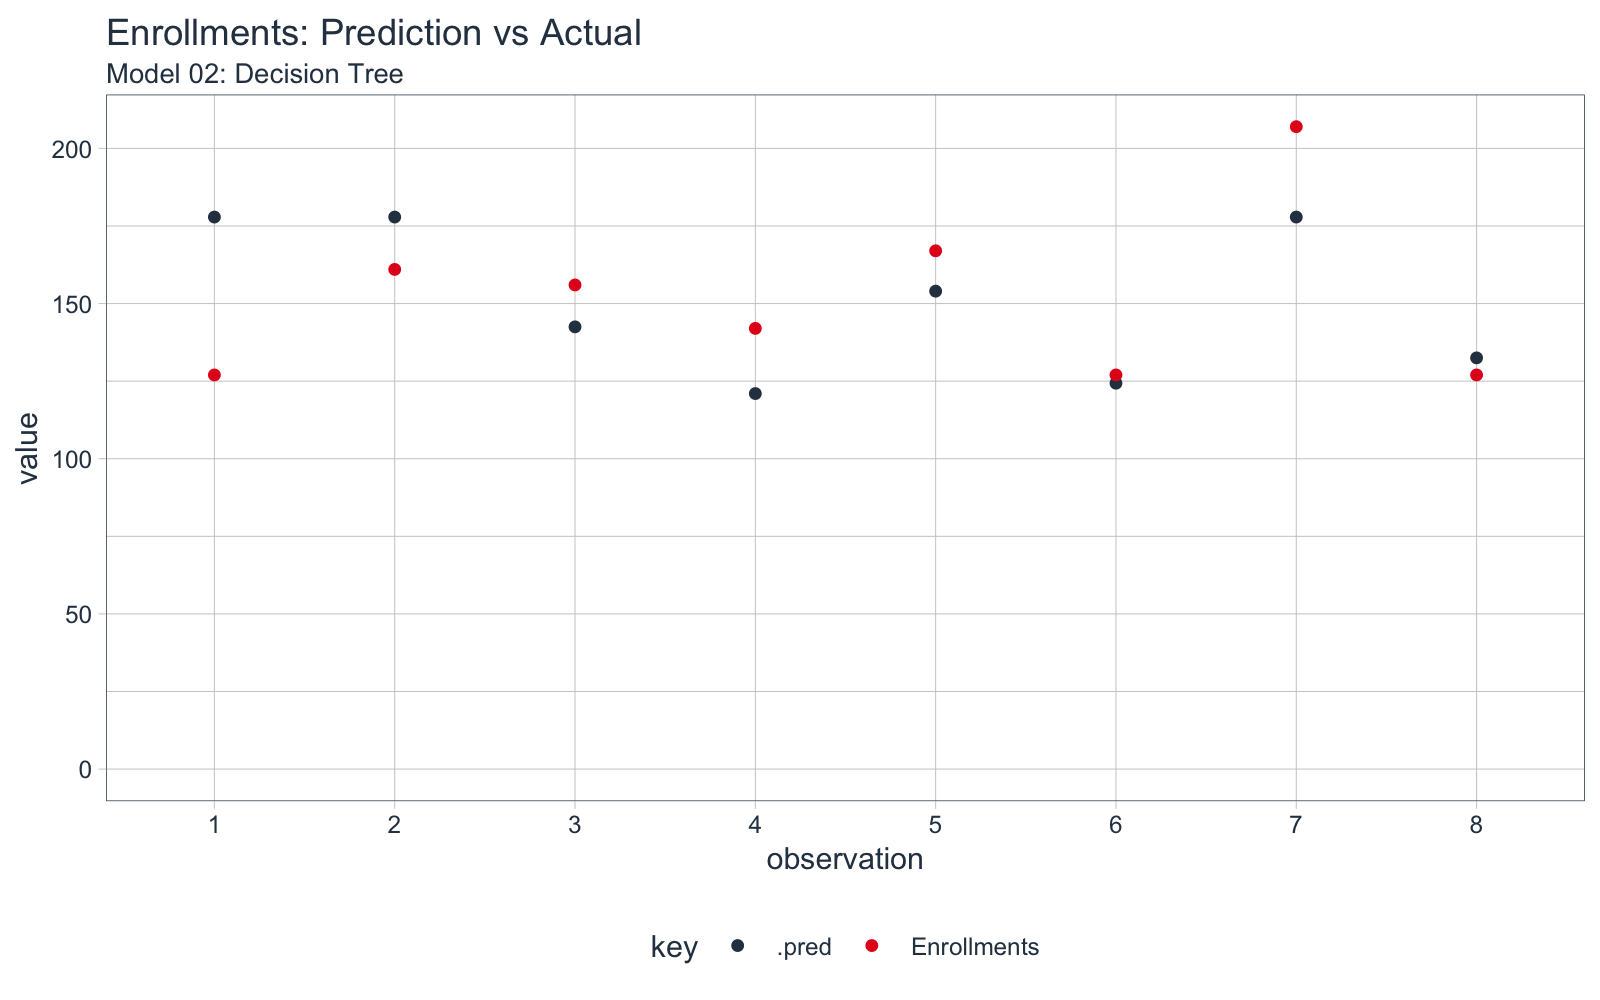

In [ ]:
model_02_decision_tree$fit %>%
    rpart.plot(
        roundint = FALSE, 
        cex = 0.8, 
        fallen.leaves = TRUE,
        extra = 101, 
        main = "Model 02: Decision Tree")

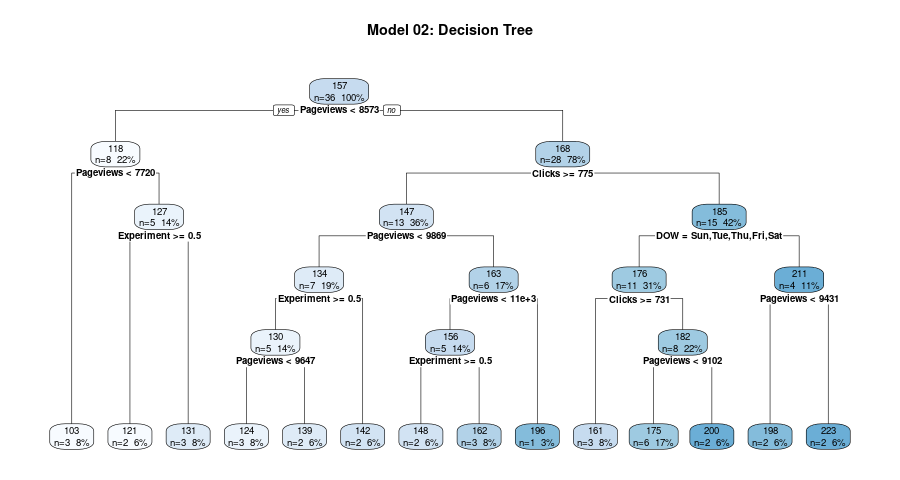

**Our new model has roughly the same accuracy to +/-18 enrollments (MAE) as the linear regression model.**

**Experiment shows up towards the bottom of the tree. The rules indicate a when Experiment >= 0.5, there is a drop in enrollments.**

# XG Boost

The final model we’ll implement is an xgboost model. Several key tuning parameters include:

mtry: The number of predictors that will be randomly sampled at each split when creating the tree models.

trees: The number of trees contained in the ensemble.

min_n: The minimum number of data points in a node that are required for the node to be split further.

tree_depth: The maximum depth of the tree (i.e. number of splits).

learn_rate: The rate at which the boosting algorithm adapts from iteration-to-iteration.

loss_reduction: The reduction in the loss function required to split further.

sample_size: The amount of data exposed to the fitting routine.

In [24]:
set.seed(123)
model_03_xgboost <- boost_tree(
        mode = "regression",
        mtry = 100, 
        trees = 1000, 
        min_n = 8, 
        tree_depth = 6, 
        learn_rate = 0.2, 
        loss_reduction = 0.01, 
        sample_size = 1) %>%
    set_engine("xgboost") %>%
    fit(Enrollments ~ ., data = train_tbl %>% select(-row_id))

In [25]:
# knitr::kable() used for pretty tables
model_03_xgboost %>% 
    calc_metrics(test_tbl) %>%
    knitr::kable()



|.metric |.estimator |  .estimate|
|:-------|:----------|----------:|
|rmse    |standard   | 20.5911658|
|rsq     |standard   |  0.4683664|
|mae     |standard   | 17.5331612|

In [ ]:
model_03_xgboost %>% plot_predictions(test_tbl) +
    labs(title = "Enrollments: Prediction vs Actual",
         subtitle = "Model 02: Decision Tree")

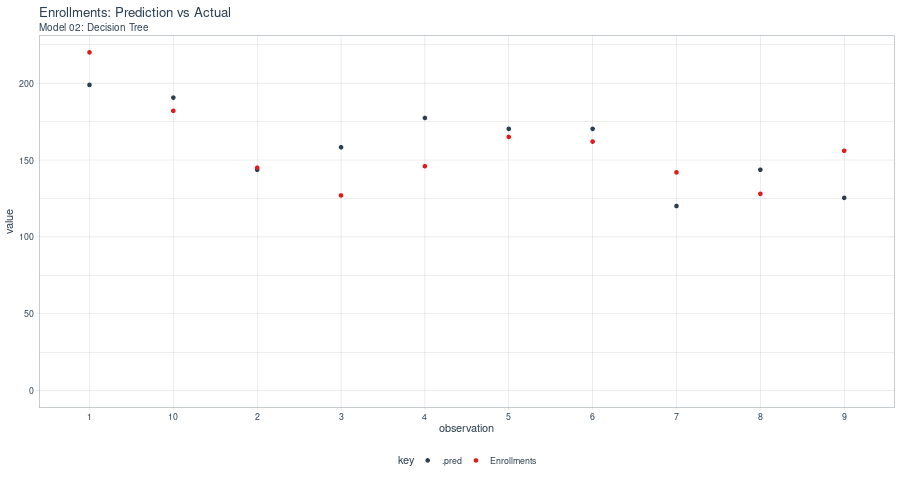

In [26]:
xgboost_feature_importance_tbl <- model_03_xgboost$fit %>%
    xgb.importance(model = .) %>%
    as_tibble() %>%
    mutate(Feature = as_factor(Feature) %>% fct_rev())

xgboost_feature_importance_tbl %>% knitr::kable()



|Feature    |      Gain|     Cover| Frequency|
|:----------|---------:|---------:|---------:|
|Pageviews  | 0.5551214| 0.5979430| 0.5762712|
|Clicks     | 0.3824188| 0.2145172| 0.2364613|
|Experiment | 0.0624598| 0.1875398| 0.1872675|

In [ ]:
xgboost_feature_importance_tbl %>%
    ggplot(aes(x = Gain, y = Feature)) +
    geom_point(color = "#2C3E50") +
    geom_label(aes(label = scales::percent(Gain)), 
               hjust = "inward", color = "#2C3E50") +
    expand_limits(x = 0) +
    theme_tq() +
    labs(title = "XGBoost Feature Importance") 

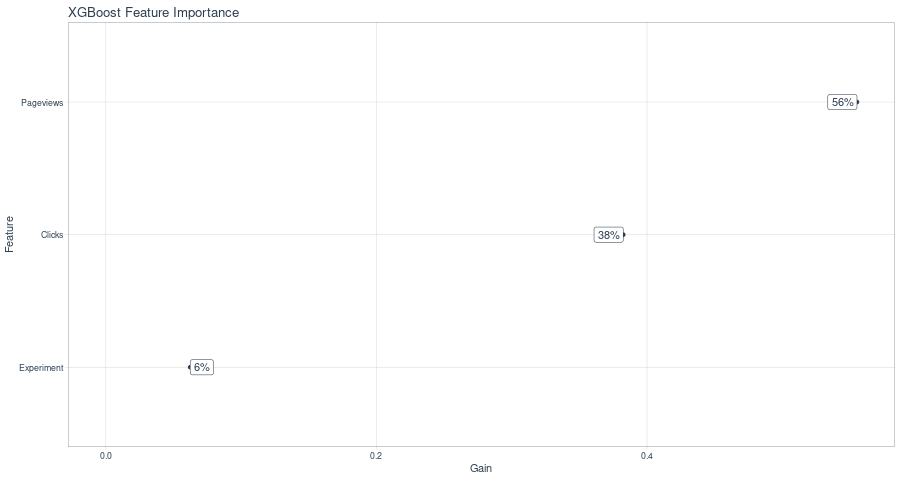

**XG Boost Conclusion**

The information gain is 94% from Pageviews and Clicks combined.

Experiment has about a 6% contribution to information gain, indicating it’s still predictive (just not nearly as much as Pageviews).

This tells a story that if Enrollments are critical, Udacity should focus on getting Pageviews.

**Key Points**

The XGBoost model error has dropped to +/-17 Enrollments.

The XGBoost shows that Experiment provides an information gain of 6%

The XGBoost model tells a story that Udacity should be focusing on Page Views and secondarily Clicks to maintain or increase Enrollments. The features drive the system.

# Conclusion

What Should Udacity Do?

If Udacity wants to maximimize enrollments, it should focus on increasing Page Views from qualified candidates. Page Views is the most important feature in 2 of 3 models.

If Udacity wants alert people of the time commitment, the additional popup form is expected to decrease the number of enrollments. The negative impact can be seen in the decision tree (when Experiment <= 0.5, Enrollments go down) and in the linear regression model term (-17.6 Enrollments when Experiment = 1). Is this OK? It depends on what Udacity’s goals are.

But this is where the business and marketing teams can provide their input developing strategies to maximize their goals - More users, more revenue, and/or more course completions.